### We start by importing the necessary libraries and loading the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

In [2]:
df=pd.read_csv('...../T1.csv')

### let's investigate and explore our dataset.

In [3]:
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


### We see that our dataset contains 5 variables about wind turbines:

In [4]:
df.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


### It appears that we have some outliers that require further investigation. For the time being, let's check if there are any NaN values or duplicates in our data.

In [5]:
df.isna().sum()

Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64

In [6]:
df.duplicated().sum()

0

### Up to this point, everything seems to be going well! Let's continue exploring our dataset, starting with the Date/Time column. We do not yet know the relevance of this variable indepth but we believe that it is of great importance since both wind speed and power can vary depending on the time of day and season. Therefore, we should first adjust the format of this column. As the data was collected only in 2018, we don't need to consider the year, and we should focus only on the month, day, and time.

In [7]:
df.dtypes

Date/Time                         object
LV ActivePower (kW)              float64
Wind Speed (m/s)                 float64
Theoretical_Power_Curve (KWh)    float64
Wind Direction (°)               float64
dtype: object

In [8]:
df['Date/Time']=pd.to_datetime(df['Date/Time'],format='%d %m %Y %H:%M')

In [9]:
df.dtypes

Date/Time                        datetime64[ns]
LV ActivePower (kW)                     float64
Wind Speed (m/s)                        float64
Theoretical_Power_Curve (KWh)           float64
Wind Direction (°)                      float64
dtype: object

In [10]:
df['Day']=df['Date/Time'].dt.day
df['Month']=df['Date/Time'].dt.month
df['Hour']=df['Date/Time'].dt.hour
df['Minute']=df['Date/Time'].dt.minute

In [11]:
df.drop('Date/Time',inplace=True,axis=1)

In [12]:
df.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Day,Month,Hour,Minute
0,380.047791,5.311336,416.328908,259.994904,1,1,0,0
1,453.769196,5.672167,519.917511,268.641113,1,1,0,10
2,306.376587,5.216037,390.900016,272.564789,1,1,0,20
3,419.645905,5.659674,516.127569,271.258087,1,1,0,30
4,380.650696,5.577941,491.702972,265.674286,1,1,0,40


### Before checking the correlation between variables let's investigate the existence of outliers which can have a very large effect on the line of best fit. This means — including outliers in your analysis can lead to misleading results.

### We start by plotting the boxplots of the studied variables and do some visual investigation

/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

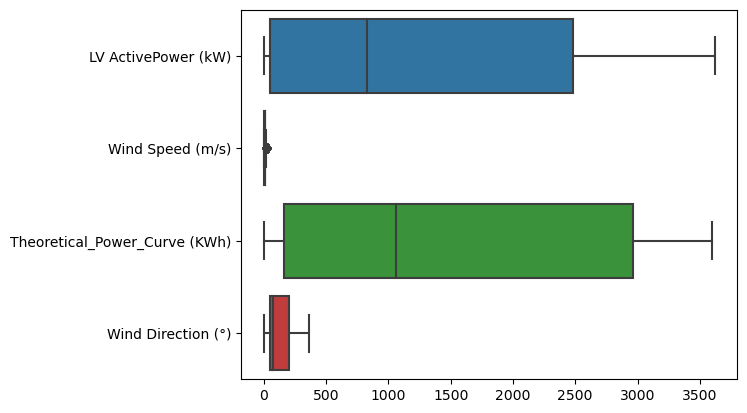

In [13]:
sns.boxplot(data=df.iloc[:, lambda df: [0,1,2,3]], orient="h")

### Obviously the Wind Speed (m/s) boxplot is not so clear so we are not sure if this variable contains any outliers or not, so let's investigate it more. 

In [14]:
q1=df['Wind Speed (m/s)'].quantile(0.25)
q3=df['Wind Speed (m/s)'].quantile(0.75)
IQR=q3-q1
upper=q3 + 1.5*IQR
lower=q1- 1.5*IQR
pd.options.display.max_rows
outliers = df[(df['Wind Speed (m/s)'] < lower) | (df['Wind Speed (m/s)'] > upper)]
outliers

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Day,Month,Hour,Minute
2396,3460.064941,19.589029,3600.0,191.041000,17,1,19,0
2407,3460.934082,20.408730,3600.0,190.896606,17,1,20,50
2408,3460.278076,20.311640,3600.0,192.326599,17,1,21,0
2409,3460.965088,20.203560,3600.0,194.577194,17,1,21,10
2410,3461.021973,21.735920,3600.0,191.814102,17,1,21,20
...,...,...,...,...,...,...,...,...
49499,3599.202881,20.886930,3600.0,209.078796,24,12,20,10
49500,3599.352051,20.566700,3600.0,207.262207,24,12,20,20
49501,3598.977051,20.452000,3600.0,206.919693,24,12,20,30
49502,3599.501953,21.018150,3600.0,206.952499,24,12,20,40


/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='Wind Speed (m/s)', ylabel='Density'>

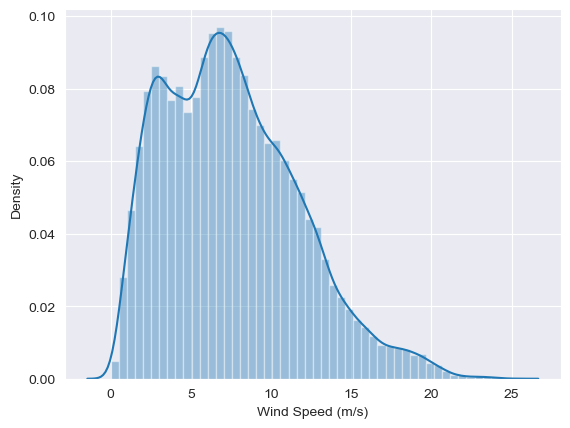

In [15]:
sns.set_style('darkgrid')
sns.distplot(df['Wind Speed (m/s)'])

### We have a right skewed distribution with around 423 outliers which will be dropped later.

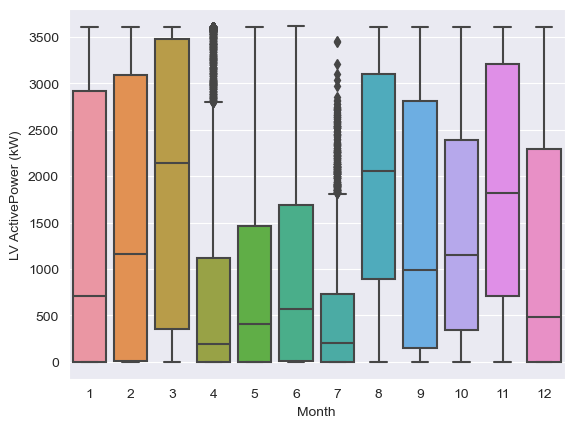

In [16]:
sns.boxplot(x="Month", y="LV ActivePower (kW)", data=df)
plt.xlabel("Month")
plt.ylabel("LV ActivePower (kW)")
plt.show()

### It appears that the active power has the widest range during the months of January, February, March, September, November, and December, which could indicate a higher wind speed during these months compared to other months in the year.

In [17]:
df['LV ActivePower (kW)'].describe()

count    50530.000000
mean      1307.684332
std       1312.459242
min         -2.471405
25%         50.677890
50%        825.838074
75%       2482.507568
max       3618.732910
Name: LV ActivePower (kW), dtype: float64

### We see that we have some values equal to zero and negative in the LV ActivePower (kW) variable. Let's investigate it more.

In [18]:
to_drop=df[df['LV ActivePower (kW)']<=0]

### We see that we have some negative Active Power values or values that equal to zero. This can happen due to a variety of reasons, such as measurement errors, equipment failures, or system limitations. In some cases, zero or negative values may also indicate that the system is not generating and it is consuming power. 

### We drop these values

In [19]:
df.drop(to_drop.index, axis=0, inplace=True)

In [20]:
df.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Day,Month,Hour,Minute
count,39692.000000,39692.000000,39692.000000,39692.000000,39692.000000,39692.000000,39692.000000,39692.000000
mean,1664.751281,8.769781,1829.739672,115.532274,15.558148,6.657211,11.693339,24.970271
std,1264.303861,3.773594,1306.418817,86.276846,8.645217,3.359769,6.982266,17.067570
min,0.000200,1.208934,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,481.681473,5.911951,595.684321,49.041458,8.000000,4.000000,5.000000,10.000000
50%,1394.047974,8.114283,1596.105035,70.241829,16.000000,7.000000,12.000000,20.000000
75%,2908.239746,11.099597,3306.484805,197.156849,23.000000,10.000000,18.000000,40.000000
max,3618.732910,25.206011,3600.000000,359.997589,31.000000,12.000000,23.000000,50.000000


### Let's check the correlation matrix.

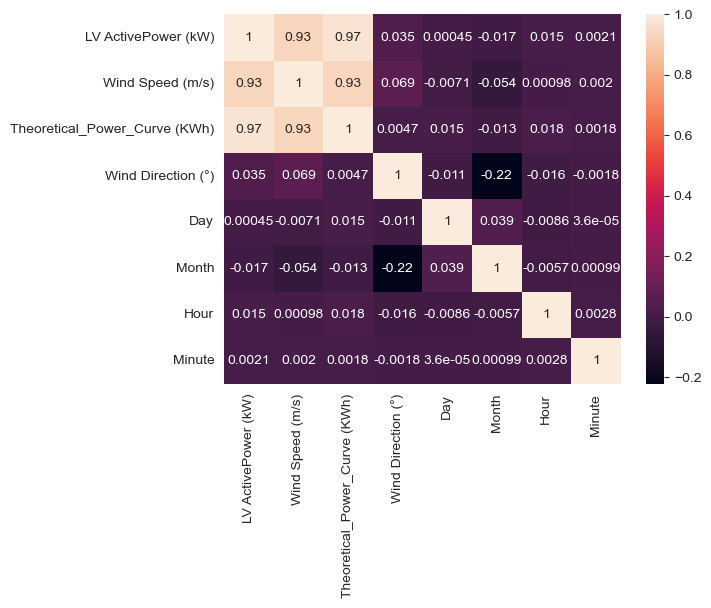

In [21]:
correlation_mat = df.corr()
sns.heatmap(correlation_mat, annot = True)
plt.show()

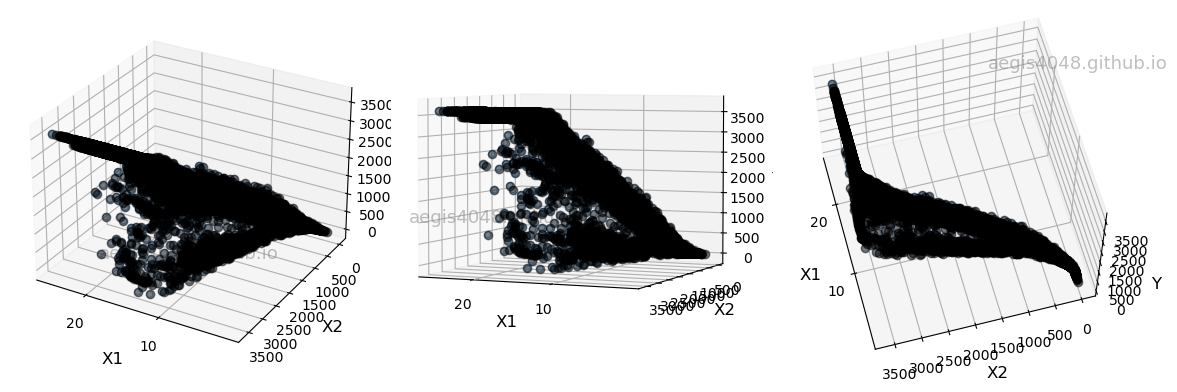

In [22]:

plt.style.use('default')

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(df['Wind Speed (m/s)'], df['Theoretical_Power_Curve (KWh)'].values, 
            df['LV ActivePower (kW)'].values, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.scatter(df['Wind Speed (m/s)'], df['Theoretical_Power_Curve (KWh)'].values, 
            df['LV ActivePower (kW)'].values, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
    ax.set_xlabel('X1', fontsize=12)
    ax.set_ylabel('X2', fontsize=12)
    ax.set_zlabel('Y', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')

ax1.text2D(0.5, 0.32, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax1.transAxes, color='grey', alpha=0.5)
ax2.text2D(0.3, 0.42, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax2.transAxes, color='grey', alpha=0.5)
ax3.text2D(0.85, 0.85, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax3.transAxes, color='grey', alpha=0.5)

ax1.view_init(elev=28, azim=120)
ax2.view_init(elev=4, azim=114)
ax3.view_init(elev=60, azim=165)

fig.tight_layout()           

### To predict the LV Active Power (KW), we first need to identify the factors responsible for generating more power. Upon investigating the correlation matrix and the plots above, we observe that the wind speed and theoretical power curve variables are highly correlated with the target variable. However, the other variables are not determinant and will be dropped. Additionally, there is multicollinearity between the theoretical power curve and the wind speed variables.

### Although wind speed and the theoretical power curve are related, they are not the same thing and provide different information. Wind speed is a physical measurement, while the theoretical power curve is a mathematical model based on the turbine's design. Therefore, we will keep both of the variables and apply Linear least squares with l2 regularization (Ridge Regression ) as well as we will handle the outliers by the isolation forest algorithm. 

In [23]:
X,y=df[['Wind Speed (m/s)','Theoretical_Power_Curve (KWh)']].values,df['LV ActivePower (kW)'].values
X_train, X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
iso = IsolationForest(contamination=0.01)
yhat = iso.fit_predict(X_train)
mask = yhat != -1
X_train, y_train= X_train[mask, :], y_train[mask]
print(X_train.shape, y_train.shape)

(31435, 2) (31435,)


In [24]:
clf = Ridge(alpha=1)
y_train_pred=clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.9525893000852761

### let's now test our model!

In [25]:
y_test_pred=clf.predict(X_test)

In [26]:
print('r2 is:',clf.score(X_test,y_test_pred))
print('mse is:',mean_squared_error(y_test, y_test_pred))
print('mae is:',mean_absolute_error(y_test, y_test_pred))

r2 is: 1.0
mse is: 78566.44402098536
mae is: 139.38903739917177


In [27]:
print(clf.coef_)
print(clf.intercept_)

[62.03927081  0.77930146]
-303.403574427306


### We print the coefficients and intercept of our equation which is as follows: y_pred=(62.0x_1+0.77x_2)-303.40


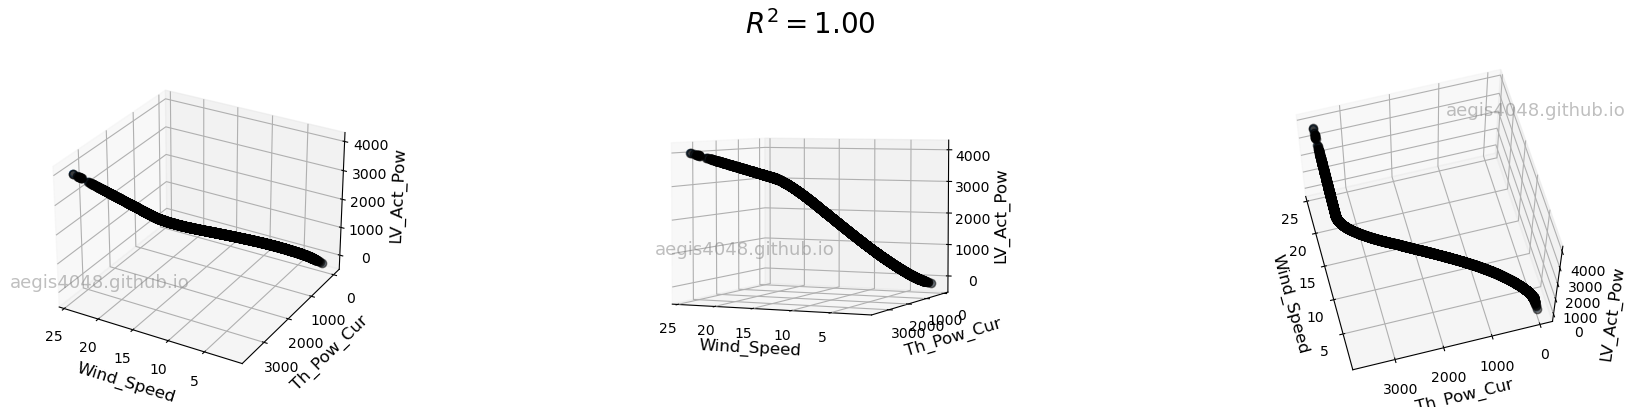

In [28]:
plt.style.use('default')

fig = plt.figure(figsize=(20, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

arr1 = np.split(X_test, 2, axis=1) 
x1=arr1[0].flatten()
x2=arr1[1].flatten()

for ax in axes:
    ax.plot(x1, x2, y_test_pred, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.scatter(x1, x2, y_test_pred, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
    ax.set_xlabel('Wind_Speed', fontsize=12)
    ax.set_ylabel('Th_Pow_Cur', fontsize=12)
    ax.set_zlabel('LV_Act_Pow', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')

ax1.text2D(0.2, 0.32, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax1.transAxes, color='grey', alpha=0.5)
ax2.text2D(0.3, 0.42, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax2.transAxes, color='grey', alpha=0.5)
ax3.text2D(0.85, 0.85, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax3.transAxes, color='grey', alpha=0.5)

ax1.view_init(elev=28, azim=120)
ax2.view_init(elev=4, azim=114)
ax3.view_init(elev=60, azim=165)

fig.suptitle('$R^2 = %.2f$' % clf.score(X_test,y_test_pred), fontsize=20)

fig.tight_layout()

### An R-squared value of 1.0 indicates that the model perfectly fits the data and can explain all the variance in the dependent variable using the independent variables.
### The MSE value of 78566.44 indicates that, on average, the squared difference between the predicted and actual values is 78566.44.

### The MAE value of 139.39 indicates that, on average, the absolute difference between the predicted and actual values is 139.39. 

### Overall, based on these metrics, it seems that the model is performing well the test data. 

# Thank you!